# Fun with Support Vector Machines!

This tutorial steps through how to parallelize the SVM algorithm, to make it faster. It is organized as follows:

__Part 0:__ generate linearly separable, 2-class data

__Part 1:__ implement SVM using cvxopt, a QP solver package, to illustrate basic problem setup

__Part 2:__ implement primal-dual interior point method, a QP solver, by hand and use it to implement SVM

__Part 3:__ use low-rank approximations of size $n \times n$ matrix to speed up Part 2 implementation

__Part 4:__ use parallel computation, via PySpark, to further speed up Part 3 implementation

__Part 5:__ run experiments comparing the speeds of implementations from Parts 1-4

I based this project off a 2007 NIPS paper entitled "Parallelizing Support Vector Machines on Distributed Computers", by Zhu et al: https://papers.nips.cc/paper/3202-parallelizing-support-vector-machines-on-distributed-computers

Their (much faster) implementation, written in C, can be found here: https://code.google.com/archive/p/psvm/source/default/source?page=1

For Part 2, this textbook was a useful reference: http://web.stanford.edu/~boyd/cvxbook/. I am also grateful to Nic Dalmasso and Ben Leroy, who helped me understand PDIPM and debug my implementation.

My goal for this project was to learn more about an interesting problem, and to share what I've learned in a tutorial that others may find useful.

In [57]:
import sys
import numpy as np
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
import pickle
from cvxopt import matrix, solvers

# 0) generate data

Here we generate a small number of 2-dim data points from two linearly separable classes, so that we can easily visualize the solution. (n=100, p=2)

In practice, n and p can both be much larger, and there are various ways to extend SVM to multiclass classification.

The specific generating distribution doesn't really matter; I chose the multivariate normal distribution for simplicity.

In [2]:
def generate_data(n=50, d=2, sigma1=0.3, sigma2=0.2, toPickle=True,
                 filename='gaussiandata.pickle'):
    mu1 = np.ones((d,))
    mu2 = 3 * np.ones((d,))
    Sigma1 = np.diag(sigma1 * np.ones((d,)))
    Sigma2 = np.diag(sigma2 * np.ones((d,)))

    x1 = np.random.multivariate_normal(mu1, Sigma1, n)
    y1 = np.ones((x1.shape[0],))
    x2 = np.random.multivariate_normal(mu2, Sigma2, n)
    y2 = -np.ones((x2.shape[0],))
    x = np.concatenate((x1, x2), axis = 0)
    y = np.concatenate((y1, y2), axis = 0)

    if toPickle:
        with open(filename, 'wb') as f:
            pickle.dump((x, y), f)

In [4]:
def read_data(f):
    with open(f, 'rb') as f:
        data = pickle.load(f)
    return data[0], data[1]

In [5]:
def plot_data(x, y, colors=['red','blue']):
    labels = np.unique(y)
    for i in range(len(labels)):
        x_label = x[y == labels[i]]
        plt.scatter(x_label[:, 0], x_label[:, 1], c = colors[i])
    plt.show()

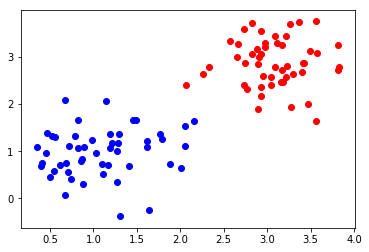

In [54]:
#generate_data(n=50, d=2, toPickle=True, filename='gaussiandata.pickle')
x, y = read_data('gaussiandata.pickle')
plot_data(x, y)

# 1) generic QP method ($O(n^3)$)

The SVM finds the vector $w$ which is normal to the maximum margin linear separator, where the margin is the perpendicular distance from the linear separator to the closest point.
$$ \underset{w,\xi_1,\ldots,\xi_m}{\arg\min} \|w\|^2 + C \sum_{i=1}^m \xi_i $$
s.t. 
$$ y_i w \cdot x_i \geq 1 - \xi_i,\ \ \forall i $$
$$ \xi_i \geq 0,\ \forall i $$

The Lagrangian dual problem for SVM is:
$$ \min_{\alpha \in \mathbb{R}^n} \frac{1}{2} \alpha^T Q \alpha - \alpha^T \boldsymbol{1} $$
s.t.
$$ 0 \leq \alpha \leq C $$
$$ \alpha^T y = 0 $$
where
$$ [Q]_{ij} = y_i y_j K(x_i)^T K(x_j) $$

## 1a) kernels

In [7]:
def linear_kernel(x):
    return x.dot(x.T)

RBF Kernel: $$K(x, y) = \exp\Big({-\gamma \|x-y\|^2}\Big) = \exp\Big({-\gamma \Big(\|x\|^2 + \|y\|^2 - 2\|x\|\|y\|\Big)}\Big) $$

In [8]:
def rbf_kernel(x, gamma=1):
    
    n = x.shape[0]
    
    x_sq = np.array([np.linalg.norm(xi)**2 for xi in x])
    x_j_sq = np.array([x_sq,] * n)
    x_i_sq = x_j_sq.T
    
    cross_terms = x.dot(x.T)
    
    K = np.exp(-0.5 * gamma * (x_i_sq + x_j_sq - 2*cross_terms))

    return K

## 1b) pick your favorite QP solver

The Python package cvxopt has a function solvers.qp which solves QP problems. It takes the following arguments: 

solvers.qp(Q, l, G, h, A, b) corresponds to

$$ \max_{w} \frac{1}{2}w^T Q w + l^T w  $$
s.t.
$$ Gw \leq h $$
$$ Aw = b $$

In [9]:
def run_SVM_cvxopt(x, y, kernel=linear_kernel, soft=False, C=1):
    
    n = x.shape[0]
    
    K = kernel(x)
    Q = matrix(np.diag(y.reshape(-1)).dot(K).dot(np.diag(y.reshape(-1))))
    l = matrix(-np.ones((n, 1)))
    
    if not soft:  # hard margin SVM
        G = matrix(-np.eye(n))
        h = matrix(np.zeros(n))
    else:  # soft margin SVM
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h = matrix(np.hstack((np.zeros(n), C * np.ones(n))))
        
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    # pick your favorite QP solver
    sol = solvers.qp(Q, l, G, h, A, b)
    alpha = np.array(sol['x'])
    
    return alpha

We can translate the dual solution $\alpha$ back into the primal solution $w$ using
$$ w = \sum_{i=1}^n y_i \alpha^T K(x_i) $$

In [10]:
def alpha_to_w(alpha):
    
    w = np.sum(y[:, None] * alpha * x, axis = 0)
    support_vecs = (alpha > 1e-4).reshape(-1)
    b = (y[support_vecs] - np.dot(x[support_vecs], w))[0]
    norm = np.linalg.norm(w)
    w /= norm
    b /= norm
    
    return w, b

## 1c) plots

In [11]:
def plot_data_with_SVM_separator(x, y, alpha, colors=['red','blue']):
    fig, ax = plt.subplots()
    
    w, b = alpha_to_w(alpha=alpha)
    
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x_i = np.arange(0, 6)
    ax.plot(x_i, x_i * slope + intercept, 'k-')
    
    labels = np.unique(y)
    for i in range(len(labels)):
        x_label = x[y == labels[i]]
        ax.scatter(x_label[:, 0], x_label[:, 1], c = colors[i])

The output of solvers.qp shows the primal and dual objective values in the first two columns. Note that these eventually converge to the same value, and their difference (the duality gap in the third column) converges to 0. The last two columns are the primal and dual residuals, which converge to zero.

The two plots show 1) a hard SVM solution, where every point must be correctly classified with sufficient margin, 2) a soft SVM solution, where points are allowed to violate the hard SVM condition by incurring a penalty

     pcost       dcost       gap    pres   dres
 0: -1.1243e+01 -2.2357e+01  3e+02  1e+01  2e+00
 1: -1.7114e+01 -1.3816e+01  1e+02  5e+00  7e-01
 2: -2.6505e+01 -1.4915e+01  7e+01  3e+00  4e-01
 3: -1.1490e+01 -6.6554e+00  1e+01  5e-01  6e-02
 4: -5.2065e+00 -5.5513e+00  4e-01  6e-04  8e-05
 5: -5.3944e+00 -5.3981e+00  4e-03  6e-06  8e-07
 6: -5.3964e+00 -5.3965e+00  4e-05  6e-08  8e-09
 7: -5.3965e+00 -5.3965e+00  4e-07  6e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0047e+00 -7.7411e+00  4e+02  2e+01  1e-14
 1: -7.7562e-01 -7.3768e+00  1e+01  4e-01  1e-14
 2: -5.1899e-01 -2.3237e+00  2e+00  5e-16  2e-15
 3: -7.0533e-01 -1.0444e+00  3e-01  3e-16  2e-15
 4: -7.9491e-01 -8.9961e-01  1e-01  2e-16  2e-15
 5: -8.2171e-01 -8.5729e-01  4e-02  1e-16  1e-15
 6: -8.3378e-01 -8.4087e-01  7e-03  1e-16  2e-15
 7: -8.3667e-01 -8.3718e-01  5e-04  2e-16  2e-15
 8: -8.3689e-01 -8.3690e-01  7e-06  1e-16  2e-15
 9: -8.3689e-01 -8.3689e-01  7e-08  2e-16  2e-1

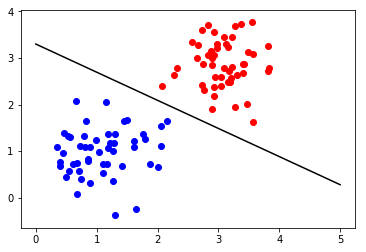

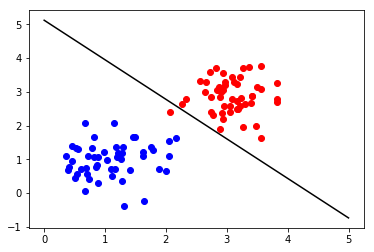

In [12]:
x, y = read_data('gaussiandata.pickle')

alpha_cvx_hard = run_SVM_cvxopt(x, y, kernel=linear_kernel, soft=False)
plot_data_with_SVM_separator(x, y, alpha_cvx_hard)

alpha_cvx_soft = run_SVM_cvxopt(x, y, kernel=linear_kernel, soft=True, C=0.05)
plot_data_with_SVM_separator(x, y, alpha_cvx_soft)

# 2) primal-dual interior point method (PDIPM) ($O(n^3)$)

PDIPM is one specific type of QP method we can implement by hand. We choose this method because it is amenable to parallelization.

We can rewrite the dual SVM problem as:
$$ \min_{\alpha \in \mathbb{R}^n} \frac{1}{2} \alpha^T Q \alpha + C \sum_{i=1}^n \lambda_i $$
s.t.
$$ \alpha^T y = 0 $$
$$ Q\alpha - \lambda  + \xi + \nu y = \boldsymbol{1} $$
$$ \xi, \lambda \geq 0 $$
where
$$ [Q]_{ij} = y_i y_j K(x_i)^T K(x_j) $$

## 2a) helper functions

In order for primal-dual IPM to work, we must start with a feasible point. The feasibility conditions on $\alpha$ are:
$$ \alpha^T y = 0 $$
$$ 0 \leq \alpha \leq C $$

In [13]:
def find_starting_alpha(y, C=1):
    
    # proportion of +1's in y
    y_pos_prop = np.sum((y + 1) / 2) / len(y)
    
    alpha = np.array([(1 - y_pos_prop) * C if y_i == 1 else y_pos_prop * C for y_i in y])
    
    # feasibility conditions
    assert(abs(np.dot(alpha,y)) <= 1e-8)
    assert((alpha >= 0).prod() == 1)
    assert((alpha <= C).prod() == 1)
    
    return alpha

Recall the original dual objective: $$ \frac{1}{2} \alpha^T Q \alpha - \alpha^T \boldsymbol{1} $$

In [14]:
def calc_dual_objective(x, y, alpha, Q):
    return (0.5 * alpha.T.dot(Q).dot(alpha) - alpha.sum())

We define the dual residual as: $$ Q\alpha - \lambda  + \xi + \nu y - \boldsymbol{1} $$
and we iterate until it converges to 0, i.e. the corresponding constraint is satisfied.

In [15]:
def calc_dual_residual(n, Q, alpha, lambduh, ksi, nu, y):
    return Q.dot(alpha) - np.eye(n).dot(lambduh) + np.eye(n).dot(ksi) + nu*y -np.ones((n,))

We define the central residual as:
$$ \begin{bmatrix}
vec\Big(\lambda_i\alpha_i - \frac{1}{t}\Big) \\
vec\Big(\xi_i(C-\alpha_i) - \frac{1}{t}\Big)
\end{bmatrix} $$
and we iterate until it converges to 0.

In [16]:
def calc_central_residual(n, lambduh, ksi, helper_vector, t):
    helper_matrix = np.vstack((np.hstack((np.diag(lambduh), np.zeros((n,n)))),
                               np.hstack((np.zeros((n,n)), np.diag(ksi)))))
    central_residual = -helper_matrix.dot(helper_vector) - np.ones((2 * n,)) / t
    return helper_matrix, central_residual

This helper vector shows up in several places. When running backtracking to find a valid step size $s$, this helper vector must be $\leq 0$, which means it satisfies the feasibility conditions:
$$ \alpha^T y = 0 $$
$$ 0 \leq \alpha \leq C $$

In [17]:
def calc_helper_vector(alpha, n, C=1):
    return np.concatenate((-alpha, alpha - C * np.ones((n,))))

## 2b) gradient calculation

To calculate the gradient, we solve the following equation:
$$ \begin{bmatrix}
Q & -I_n & I_n & y \\
diag(\lambda) & diag(\alpha) & 0_n & 0_n \\
-diag(\xi) & 0_n & diag(C-\alpha) & 0_n \\
y^T & 0_n^T & 0_n^T & 0
\end{bmatrix}
\begin{bmatrix}
\Delta\alpha \\
\Delta\lambda \\
\Delta\xi \\
\Delta\nu
\end{bmatrix}
=
-\begin{bmatrix}
Q\alpha - \lambda  + \xi + \nu y - \boldsymbol{1} \\
vec\Big(\lambda_i\alpha_i - \frac{1}{t}\Big) \\
vec\Big(\xi_i(C-\alpha_i) - \frac{1}{t}\Big) \\
y^T \alpha
\end{bmatrix}$$
for the variables $\Delta\alpha, \Delta\lambda, \Delta\xi, \Delta\nu$. We do so by inverting the matrix on the left.

In [19]:
def calc_gradient(n, Q, alpha, y, lambduh, ksi, nu, helper_vector, t):
    
    dual_residual = calc_dual_residual(n=n, Q=Q, alpha=alpha, y=y, lambduh=lambduh, ksi=ksi, nu=nu)
    helper_matrix, central_residual = calc_central_residual(n=n, lambduh=lambduh, ksi=ksi,
                                                            helper_vector=helper_vector, t=t)
    primal_residual = alpha.dot(y).reshape(1,)
    residuals = np.concatenate((dual_residual, central_residual, primal_residual))
    assert dual_residual.shape == (n,)
    assert central_residual.shape == (2*n,)
    assert residuals.shape == (3*n + 1,)
    
    matrix_top = np.hstack((Q, np.hstack((-np.eye(n), np.eye(n))), y.reshape(-1, 1)))
    matrix_middle = np.hstack((-helper_matrix.dot(np.vstack((-np.eye(n), np.eye(n)))),
                               np.diag(-helper_vector), np.zeros((2*n,)).reshape(-1, 1)))
    matrix_bottom = np.concatenate((y, np.zeros((2*n + 1,)))).reshape(1, -1)
    assert matrix_top.shape == (n, 3*n+1)
    assert matrix_middle.shape == (2*n, 3*n +1)
    assert matrix_bottom.shape == (1, 3*n + 1)

    matrix_full = np.vstack((matrix_top, matrix_middle, matrix_bottom))
    assert matrix_full.shape == (3*n +1, 3*n+1)
    
    gradient = -(np.linalg.inv(matrix_full)).dot(residuals)
    assert gradient.shape == (3*n +1, )
    
    return gradient, residuals

## 2c) step size calculation

First, calculate a max step size, which we gradually reduce until we find a valid step size. The largest this can be is 1, which corresponds to pure (undamped) Newton's method.

In [20]:
def calc_s_max(lambduh, ksi, gradient, n):
    
    central_vars = np.concatenate((lambduh, ksi))
    central_vars_gradient = gradient[n:3*n]
    central_vars_gradient_neg = central_vars_gradient < 0
    if not np.all(central_vars_gradient_neg == False):
        min_ratio = np.min(np.divide(central_vars[central_vars_gradient_neg],
                                     -central_vars_gradient[central_vars_gradient_neg]))
        s_max = min([1, min_ratio])
    else:
        s_max = 1
    
    return s_max

Gradually reduce the step size until we find one that works.

In [21]:
def calc_step_size(alpha, lambduh, ksi, nu, n, C, Q, y, t, a, b, gradient, residuals):
    
    s_max = calc_s_max(lambduh=lambduh, ksi=ksi, gradient=gradient, n=n)
    s = 0.99 * s_max

    found_s = False
    while not found_s:

        alpha_try = alpha + s*gradient[ : n]
        lambduh_try = lambduh + s*gradient[n : 2*n]
        ksi_try = ksi + s*gradient[2*n : 3*n]
        nu_try = nu + s*gradient[-1]

        helper_vector_try = calc_helper_vector(alpha=alpha_try, n=n, C=C)
        dual_residual_try = calc_dual_residual(n=n, Q=Q, alpha=alpha_try, lambduh=lambduh_try,
                                               ksi=ksi_try, nu=nu_try, y=y)
        _, central_residual_try = calc_central_residual(n=n, lambduh=lambduh_try, ksi=ksi_try,
                                                        helper_vector=helper_vector_try, t=t)
        primal_residual_try = np.dot(alpha_try, y).reshape(1, )
        residuals_try = np.concatenate((dual_residual_try, central_residual_try, primal_residual_try))

        if np.all(helper_vector_try < 0) and \
        np.linalg.norm(residuals_try) <= (1 - a * s) * np.linalg.norm(residuals):
            found_s = True
        else:
            s = b * s
    
    return s, alpha_try, lambduh_try, ksi_try, nu_try, helper_vector_try, \
        primal_residual_try, dual_residual_try

## 2d) PDIPM method and results

Given all the ingredients above, PDIPM simply repeats until convergence the following iterative update steps:
- $\alpha \leftarrow \alpha + \Delta \alpha$
- $\lambda \leftarrow \lambda + \Delta \lambda$
- $\xi \leftarrow \xi + \Delta \xi$
- $\nu \leftarrow \nu + \Delta \nu$

Convergence means the below conditions are all satisfied
- $\alpha$ is primal feasible
- $\lambda$, $\xi$, and $\nu$ are dual feasible
- surrogate gap $ \lambda \alpha - \xi (C - \alpha) $ is below threshold



In [22]:
def solve_SVM_PDIPM(x, y, n, Q, alpha, lambduh, ksi, nu, C=1, mu=10, feasible_tol=1e-6, dual_gap_tol=2e-6,
                    a=0.01, b=0.5, verbose=True, gradient_method="together", p=1):
    
    helper_vector = calc_helper_vector(alpha=alpha, n=n, C=C)
    eta = -np.dot(helper_vector, np.concatenate((lambduh, ksi)))
    
    dual_objectives = []
    dual_objective = calc_dual_objective(x, y, alpha, Q)
    dual_objectives.append(dual_objective)
    
    i = 0
    converged = False
    while not converged:
        
        t = 2 * n * mu/ eta
        
        # calculate gradients: for alpha, lambduh, ksi, nu
        if gradient_method == "together":
            gradient, residuals = calc_gradient(n=n, Q=Q, alpha=alpha, y=y, lambduh=lambduh, ksi=ksi,
                                                nu=nu, helper_vector=helper_vector, t=t)
        elif gradient_method == "separate":
            gradient, residuals = calc_gradient_separate(n=n, Q=Q, C=C, alpha=alpha, y=y, lambduh=lambduh,
                                                         ksi=ksi, nu=nu, helper_vector=helper_vector, t=t)
        elif gradient_method == "lowrank":
            H = calc_ICF(Q=Q, p=p)
            gradient, residuals = calc_gradient_lowrank(n=n, p=p, Q=Q, H=H, C=C, alpha=alpha, y=y,
                                                        lambduh=lambduh, ksi=ksi, nu=nu,
                                                        helper_vector=helper_vector, t=t)
        elif gradient_method == "parallel":
            H = calc_ICF_parallel(Q=Q, p=p)
            gradient, residuals = calc_gradient_lowrank(n=n, p=p, Q=Q, H=H, C=C, alpha=alpha, y=y,
                                                        lambduh=lambduh, ksi=ksi, nu=nu,
                                                        helper_vector=helper_vector, t=t)
        else:
            raise Exception("gradient_method must either be 'together' or 'separate'!")
        
        # calculate step size, update by taking step in direction of gradient
        s, alpha, lambduh, ksi, nu, helper_vector, primal_residual, dual_residual = \
        calc_step_size(alpha=alpha, lambduh=lambduh, ksi=ksi, nu=nu, n=n, C=C, Q=Q,
                       y=y, t=t, a=a, b=b, gradient=gradient, residuals=residuals)
        
        # compute surrogate duality gap and feasibility gap
        eta = -np.dot(helper_vector, np.concatenate((lambduh, ksi)))
        feasible_gap = np.sqrt(np.linalg.norm(primal_residual) + np.linalg.norm(dual_residual))
        if feasible_gap <= feasible_tol and eta <= dual_gap_tol:
            converged = True
        
        dual_objective = calc_dual_objective(x=x, y=y, alpha=alpha, Q=Q)
        dual_objectives.append(dual_objective)
        
        if verbose:
            print("Iteration: %d, Objective: %f, Feasibility gap: %f, Duality gap: %f, Step size: %f" %
                  (i, dual_objective, feasible_gap, eta, s))
        i += 1

    return alpha, dual_objectives

In [23]:
# Note: mu, a, b are tuning params
def run_SVM_PDIPM(x, y, kernel=linear_kernel, C=1, mu=10, a=0.01, b=0.5, verbose=True,
                  gradient_method="together", p=1, feasible_tol=1e-6, dual_gap_tol=2e-6):
    
    n = x.shape[0]
    K = kernel(x)
    Q = np.diag(y.reshape(-1)).dot(K).dot(np.diag(y.reshape(-1)))
    
    # starting values for variables we iteratively optimize over
    alpha_start = find_starting_alpha(y, C)
    lambduh_start = np.ones((n,))
    ksi_start = np.zeros((n,))
    nu_start = 0
    
    # run solver
    alpha, dual_objectives = solve_SVM_PDIPM(x=x, y=y, n=n, Q=Q, alpha=alpha_start, lambduh=lambduh_start,
                                             ksi=ksi_start, nu=nu_start, C=C, mu=mu,
                                             feasible_tol=feasible_tol, dual_gap_tol=dual_gap_tol,
                                             a=a, b=b, verbose=verbose, gradient_method=gradient_method, p=p)
    
    return alpha, dual_objectives

In [24]:
x, y = read_data('gaussiandata.pickle')
alpha_together, dual_obj_together = run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                                                  b=0.5, verbose=True, gradient_method="together")

Iteration: 0, Objective: 0.484140, Feasibility gap: 6.804121, Duality gap: 1.247259, Step size: 0.547040
Iteration: 1, Objective: 0.410149, Feasibility gap: 6.684737, Duality gap: 1.207622, Step size: 0.034784
Iteration: 2, Objective: 0.290903, Feasibility gap: 6.460113, Duality gap: 1.134651, Step size: 0.066076
Iteration: 3, Objective: 0.121839, Feasibility gap: 6.082833, Duality gap: 1.017359, Step size: 0.113392
Iteration: 4, Objective: -0.158535, Feasibility gap: 5.317705, Duality gap: 0.797008, Step size: 0.235748
Iteration: 5, Objective: -0.372443, Feasibility gap: 4.547602, Duality gap: 0.602408, Step size: 0.268665
Iteration: 6, Objective: -0.526760, Feasibility gap: 3.779420, Duality gap: 0.436470, Step size: 0.309306
Iteration: 7, Objective: -0.613923, Feasibility gap: 3.203530, Duality gap: 0.327702, Step size: 0.281532
Iteration: 8, Objective: -0.675960, Feasibility gap: 2.703922, Duality gap: 0.244017, Step size: 0.287589
Iteration: 9, Objective: -0.719022, Feasibility ga

## 2e) plots

In [25]:
def plot_dual_objective(dual_objectives=dual_obj_together):
    plt.plot(range(len(dual_obj_together)), dual_obj_together)
    plt.xlabel('Iteration')
    plt.ylabel('Dual Objective')
    plt.title('Convergence of Dual Objective Value')

Nice to see we get the same solution as above

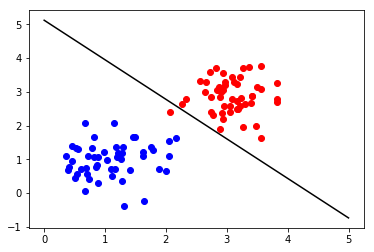

In [26]:
plot_data_with_SVM_separator(x, y, alpha_together.reshape((len(alpha_together),1)))

The objective value continues to decrease (we are performing a minimization) until it converges to the global minimum.

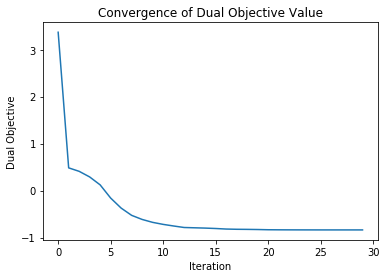

In [27]:
plot_dual_objective(dual_obj_together)

## 2f) alternative gradient calculation

Alternatively, we can calculate the gradient of each variable separately, using the following equations:
$$ \Delta\alpha = \Sigma^{-1}(z - y\Delta\nu) $$
$$ \Delta\lambda = -\lambda + vec \Big( \frac{1}{t(\alpha_i)} \Big) - diag\Big(\frac{\lambda_i}{\alpha_i} \Big)\Delta\alpha $$
$$ \Delta\xi = -\xi + vec\Big( \frac{1}{t(C-\alpha_i)} \Big) + diag\Big(\frac{\xi_i}{C-\alpha_i} \Big)\Delta\alpha $$
$$ \Delta\nu = \frac{y^T \Sigma^{-1}y + y^T\alpha}{y^T \Sigma^{-1}y} $$
where
$$ \Sigma = Q + diag\Big(\frac{\lambda_i}{\alpha_i} + \frac{\xi_i}{C-\alpha_i} \Big) $$
$$ z = -Q\alpha + \boldsymbol{1} - \nu y + \frac{1}{t} vec \Big( \frac{1}{\alpha_i} - \frac{1}{t(C-\alpha_i)} \Big) $$

This alternative calculation is what we need in order to employ parallelization, in the next sections.

In [28]:
def calc_gradient_separate(n, Q, C, alpha, y, lambduh, ksi, nu, helper_vector, t):
    
    dual_residual = calc_dual_residual(n=n, Q=Q, alpha=alpha, y=y, lambduh=lambduh, ksi=ksi, nu=nu)
    helper_matrix, central_residual = calc_central_residual(n=n, lambduh=lambduh, ksi=ksi,
                                                            helper_vector=helper_vector, t=t)
    primal_residual = alpha.dot(y).reshape(1,)
    residuals = np.concatenate((dual_residual, central_residual, primal_residual))
    
    assert dual_residual.shape == (n,)
    assert central_residual.shape == (2*n,)
    assert residuals.shape == (3*n + 1,)
    
    Sigma = Q + np.diag( lambduh / alpha + ksi / (C*np.ones((n,)) - alpha) )
    z = -Q.dot(alpha) + np.ones((n,)) - nu*y + (1 / alpha - 1 / (C*np.ones((n,)) - alpha) ) / t

    grad_nu = (y.T.dot(np.linalg.inv(Sigma)).dot(z.reshape((n,1))) + y.T.dot(alpha)) \
    / y.T.dot(np.linalg.inv(Sigma)).dot(y)
    
    grad_alpha = np.linalg.inv(Sigma).dot(z - grad_nu * y)
    
    grad_lambduh = -lambduh + 1 / (t * alpha) - np.diag(lambduh / alpha).dot(grad_alpha)
    
    grad_ksi = -ksi + 1 / (t * (C*np.ones((n,)) - alpha) ) + \
    np.diag(ksi / (C*np.ones((n,)) - alpha) ).dot(grad_alpha)
    
    gradient = np.concatenate((grad_alpha, grad_lambduh, grad_ksi, grad_nu))
    assert gradient.shape == (3*n +1, )
    
    return gradient, residuals

In [29]:
x, y = read_data('gaussiandata.pickle')
alpha_separate, dual_obj_separate = run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                                                  b=0.5, verbose=True, gradient_method="separate")

Iteration: 0, Objective: 0.484140, Feasibility gap: 6.804121, Duality gap: 1.247259, Step size: 0.547040
Iteration: 1, Objective: 0.410149, Feasibility gap: 6.684737, Duality gap: 1.207622, Step size: 0.034784
Iteration: 2, Objective: 0.290903, Feasibility gap: 6.460113, Duality gap: 1.134651, Step size: 0.066076
Iteration: 3, Objective: 0.121839, Feasibility gap: 6.082833, Duality gap: 1.017359, Step size: 0.113392
Iteration: 4, Objective: -0.158535, Feasibility gap: 5.317705, Duality gap: 0.797008, Step size: 0.235748
Iteration: 5, Objective: -0.372443, Feasibility gap: 4.547602, Duality gap: 0.602408, Step size: 0.268665
Iteration: 6, Objective: -0.526760, Feasibility gap: 3.779420, Duality gap: 0.436470, Step size: 0.309306
Iteration: 7, Objective: -0.613923, Feasibility gap: 3.203530, Duality gap: 0.327702, Step size: 0.281532
Iteration: 8, Objective: -0.675960, Feasibility gap: 2.703922, Duality gap: 0.244017, Step size: 0.287589
Iteration: 9, Objective: -0.719022, Feasibility ga

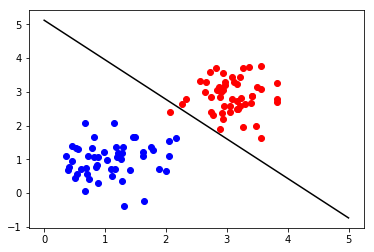

In [31]:
plot_data_with_SVM_separator(x, y, alpha_separate.reshape((len(alpha_separate),1)))

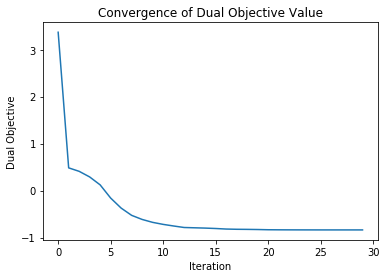

In [32]:
plot_dual_objective(dual_obj_separate)

# 3) approximate (low-rank) SVM with PDIPM ($O(np^2)$)

Inverting large matrices is slow. What if we could instead just work with low-rank approximations to the large matrix $\Sigma$?

We defined
$$ \Sigma = Q + D $$
where
$$ D = diag\Big(\frac{\lambda_i}{\alpha_i} + \frac{\xi_i}{C-\alpha_i} \Big) $$

By the Sherman-Morrison-Woodbury formula,
$$ \Sigma^{-1} = (D + Q)^{-1} \approx (D + HH^T)^{-1} $$
$$ = D^{-1} - D^{-1}H(I_p + H^TD^{-1}H)^{-1}H^TD^{-1} $$
where
$$ Q \approx HH^T $$
is a low-rank factorization of $Q$, which means
$$ Q \in \mathbb{R}^{n\times n} $$ 
$$ H \in \mathbb{R}^{n\times p},\ p < n $$
We obtain the low-rank factorization by performing an incomplete Cholesky factorization of $Q$.

So we have reduced an $O(n^3)$ matrix inverse to $O(np^2)$.

## 3a) incomplete Cholesky factorization of $\Sigma$

We perform an incomplete Cholesky factorization as follows. Let $${i_1,\ldots,i_p}$$ represent the indexes of the $p$ largest diagonal values of the matrix $Q$.

Then on each iteration $k = 1,\ldots,p$, we perform the following updates:
$$ H[i_k, k] \leftarrow \sqrt{v(i_k)} $$
Inner loop: for all $j_k=1,\ldots,n$ and $j_k \neq i_k$,
$$ H[j_k, k] \leftarrow \frac{(Q[j_k, k] - \sum_{j=1}^{k-1} H[j_k, j] * H[i_k, j])}{H[i_k, k]} $$
$$ $$
$$ v[j_k] \leftarrow v[j_k] - H[j_k, k]^2 $$

In [42]:
def calc_ICF(Q, p):
    
    n = Q.shape[0]
    H = np.zeros((n,p))
    
    v = np.diag(Q).copy()
    i_k_dict = dict(zip(v, range(n)))
    
    # take p largest diag values
    v_sort = -np.sort(-v)[ : p]
    I_k = [i_k_dict[v_k] for v_k in v_sort]
    
    for k in range(p):

        v_k = v_sort[k]

        # i_k is index of kth largest diag value
        i_k = i_k_dict[v_k]

        H[i_k, k] = np.sqrt(v_k)

        for j_k in range(n):
            if j_k in I_k:
                continue
            
            this_sum = 0
            # only need consider cols with index less than k, other cols are 0
            for l in range(k-1):
                this_sum += H[j_k, l] * H[i_k, l]
            
            H[j_k, k] = (Q[j_k, k] - this_sum) / H[i_k, k]
            
            v[j_k] -= H[j_k, k] ** 2

    error_matrix = Q - H.dot(H.T)
    error = np.diag(error_matrix).sum()
    
    return H

In [43]:
# for reference, this is a complete Cholesky factorization
def calc_CF(Q, p):
    
    n = Q.shape[0]
    H = np.zeros((n, n))
    
    for i in range(n):
        
        sum_ik_sq = 0
        for k in range(i):
            sum_ik_sq += H[i, k] ** 2
        H[i, i] = np.sqrt( Q[i, i] - sum_ik_sq )
        
        for j in range(i+1, n):
            sum_ik_jk = 0
            for k in range(i):
                sum_ik_jk += H[i, k] * H[j, k]
            H[j, i] = 1 / H[i, i] * ( Q[j, i] - sum_ik_jk )
    
    error_matrix = Q - H.dot(H.T)
    error = np.diag(error_matrix).sum()
    
    assert error <= 1e-8
    
    return H

## 3b) approximate gradient using ICF

In particular, in the gradient update step we approximate
$$ \Sigma^{-1}z \approx D^{-1}z - D^{-1}H(I + H^TD^{-1}H)^{-1}H^TD^{-1}z $$
$$ \Sigma^{-1}y \approx D^{-1}y - D^{-1}H(I + H^TD^{-1}H)^{-1}H^TD^{-1}y $$

In [34]:
def calc_gradient_lowrank(n, p, Q, H, C, alpha, y, lambduh, ksi, nu, helper_vector, t):
    
    dual_residual = calc_dual_residual(n=n, Q=Q, alpha=alpha, y=y, lambduh=lambduh, ksi=ksi, nu=nu)
    helper_matrix, central_residual = calc_central_residual(n=n, lambduh=lambduh, ksi=ksi,
                                                            helper_vector=helper_vector, t=t)
    primal_residual = alpha.dot(y).reshape(1,)
    residuals = np.concatenate((dual_residual, central_residual, primal_residual))
    
    assert dual_residual.shape == (n,)
    assert central_residual.shape == (2*n,)
    assert residuals.shape == (3*n + 1,)
    
    D = np.diag( lambduh / alpha + ksi / (C*np.ones((n,)) - alpha) )
    D_inv = np.diag( 1 / ( lambduh / alpha + ksi / (C*np.ones((n,)) - alpha) ) )
    G = np.linalg.inv(np.eye(p) + H.T.dot(D_inv).dot(H))
    
    z = -Q.dot(alpha) + np.ones((n,)) - nu*y + (1 / alpha - 1 / (C*np.ones((n,)) - alpha) ) / t
    
    Sigma_inv_z = D_inv.dot(z.reshape((n,1))) - D_inv.dot(H).dot(G).dot(H.T).dot(D_inv).dot(z.reshape((n,1)))
    Sigma_inv_y = D_inv.dot(y.reshape((n,1))) - D_inv.dot(H).dot(G).dot(H.T).dot(D_inv).dot(y.reshape((n,1)))
    
    grad_nu = (y.T.dot(Sigma_inv_z) + y.T.dot(alpha)) / y.T.dot(Sigma_inv_y)
    
    grad_alpha = (Sigma_inv_z - grad_nu * Sigma_inv_y).reshape((n,))
    
    grad_lambduh = -lambduh + 1 / (t * alpha) - np.diag(lambduh / alpha).dot(grad_alpha)
    
    grad_ksi = -ksi + 1 / (t * (C*np.ones((n,)) - alpha) ) + \
    np.diag(ksi / (C*np.ones((n,)) - alpha) ).dot(grad_alpha)
    
    gradient = np.concatenate((grad_alpha, grad_lambduh, grad_ksi, grad_nu))
    assert gradient.shape == (3*n +1, )
    
    return gradient, residuals

Observe that when we use an approximation to the matrix $Q$, we require a larger number of iterations for the SVM algorithm to converge. Moreover, the feasibility gap never quite goes to 0, because we no longer have the exact matrix $Q$ to work with.

Nonetheless, it is remarkable that with $p$ as small as $O(\sqrt{n})$, we essentially get the same solution with only negligible error.

In [92]:
x, y = read_data('gaussiandata.pickle')
n = x.shape[0]
p = int(np.floor(np.sqrt(n)))
alpha_lowrank, dual_obj_lowrank = run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                                                b=0.5, verbose=True, gradient_method="lowrank", p=p,
                                                feasible_tol=1e-4, dual_gap_tol=1e-4)

Iteration: 0, Objective: 0.801669, Feasibility gap: 7.687723, Duality gap: 2.090352, Step size: 0.087095
Iteration: 1, Objective: 0.232240, Feasibility gap: 6.429433, Duality gap: 1.777894, Step size: 0.146437
Iteration: 2, Objective: -0.106028, Feasibility gap: 5.179196, Duality gap: 1.377037, Step size: 0.242869
Iteration: 3, Objective: -0.241443, Feasibility gap: 4.601889, Duality gap: 1.158079, Step size: 0.173796
Iteration: 4, Objective: -0.271286, Feasibility gap: 4.471997, Duality gap: 1.108145, Step size: 0.047704
Iteration: 5, Objective: -0.328618, Feasibility gap: 4.198243, Duality gap: 1.004586, Step size: 0.103219
Iteration: 6, Objective: -0.385837, Feasibility gap: 3.901239, Duality gap: 0.894002, Step size: 0.121754
Iteration: 7, Objective: -0.438027, Feasibility gap: 3.626738, Duality gap: 0.792783, Step size: 0.124965
Iteration: 8, Objective: -0.484879, Feasibility gap: 3.381854, Duality gap: 0.703521, Step size: 0.124027
Iteration: 9, Objective: -0.571451, Feasibility 

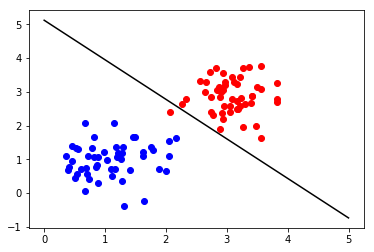

In [36]:
plot_data_with_SVM_separator(x, y, alpha_lowrank.reshape((len(alpha_lowrank),1)))

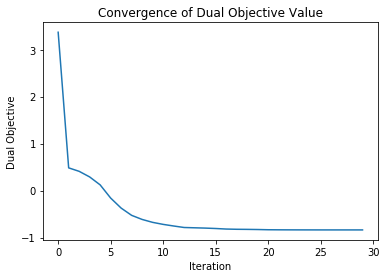

In [37]:
plot_dual_objective(dual_obj_lowrank)

# (4) parallel approximate SVM with PDIPM ($O(np^2 / m)$)

In [38]:
import findspark
findspark.init()

In [71]:
from pyspark.sql import SparkSession

In [40]:
spark = SparkSession\
    .builder\
    .appName("SVM_PySpark")\
    .getOrCreate()

In [72]:
sc = spark.sparkContext

For the finishing touch, we can parallelize the sum over $O(p)$ columns in the innermost loop to be distributed over $m$ machines, bringing our total runtime down from $O(np^2)$ to $O(np^2/m)$.

Note: to reduce the runtime of the entire algorithm to $O(np^2/m)$, we would need to store the matrix $H$ on $m$ different machines, and broadcast computations over those machines. We do not show that full implementation here, but demonstrate how to parallelize the ICF calculation to give a sense for the kinds of parallelization are needed.

In [90]:
def calc_ICF_parallel(Q, p):
    
    n = Q.shape[0]
    H = np.zeros((n,p))
    
    v = np.diag(Q).copy()
    i_k_dict = dict(zip(v, range(n)))
    
    # take p largest diag values
    v_sort = -np.sort(-v)[ : p]
    I_k = [i_k_dict[v_k] for v_k in v_sort]
    
    for k in range(p):

        v_k = v_sort[k]

        # i_k is index of kth largest diag value
        i_k = i_k_dict[v_k]

        H[i_k, k] = np.sqrt(v_k)

        for j_k in range(n):
            if j_k in I_k:
                continue
            
            # only need consider cols with index less than k, other cols are 0
            # we can use PySpark here
            H_j_k = sc.parallelize(H[j_k, : k-1])
            H_i_k = sc.parallelize(H[i_k, : k-1])
            this_sum = H_j_k.zip(H_i_k).map(lambda ij: ij[0] * ij[1]).sum()
            
            H[j_k, k] = (Q[j_k, k] - this_sum) / H[i_k, k]
            
            v[j_k] -= H[j_k, k] ** 2

    error_matrix = Q - H.dot(H.T)
    error = np.diag(error_matrix).sum()
    
    return H

# 5) Experiments

As expected, our implementations actually get slower and slower as we progress.

Part 1 (cvxopt) is the fastest, as it should be because it was implemented in C, and probably optimized for speed

In Part 2, PDIPM-separate is faster than PDIPM-together, as expected, since we are inverting $n \times n$ matrices several times which is faster than inverting one giant $(3n+1) \times (3n+1)$ matrix.

Part 3 (PDIPM-lowrank) is slower than Part 2, likely because the extra gymnastics to avoid inverting $Q$ in Python are slower than simply using np.linalg.inv, which again was written in C and optimized for speed.

Finally, Part 4 (PDIPM-parallel) is abysmally slow, with even just 1 iteration taking an hour, while 100 iterations of the others take from about a second to about a minute. This is because there is massive overhead in creating Spark variables in the way we did, and the benefits from parallelization are probably only noticeable for much larger values of $n$, and if we ran PDIPM-parallel on multiple machines.

As mentioned, the authors of the paper I cited have implemented this method in C, and their experiments show significant improvements in speed over non-parallel SVM. The goal of this my project was not to try to replicate their speed improvements, but to explore this problem of how exactly one might make SVM faster, which entails understanding how exactly one might implement SVM completely from scratch.

In [87]:
import timeit

n = 100

x, y = read_data('gaussiandata.pickle')

def method1():
    solvers.options['show_progress'] = False
    run_SVM_cvxopt(x, y, kernel=linear_kernel, soft=True, C=0.05)
    return

def method2():
    run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                  b=0.5, verbose=False, gradient_method="together")
    return

def method3():
    run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                  b=0.5, verbose=False, gradient_method="separate")
    return

def method4():
    run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                  b=0.5, verbose=False, gradient_method="lowrank",
                  p=p, feasible_tol=1e-4, dual_gap_tol=1e-4)
    return

def method5():
    run_SVM_PDIPM(x, y, kernel=linear_kernel, C=0.05, mu=10, a=0.01,
                  b=0.5, verbose=False, gradient_method="parallel",
                  p=p, feasible_tol=1e-4, dual_gap_tol=1e-4)
    return


t1 = timeit.timeit(method1, number = n)
print('cvxopt SVM:', round(t1, 2))
t2 = timeit.timeit(method2, number = n)
print('PDIPM together SVM:', round(t2, 2))
t3 = timeit.timeit(method3, number = n)
print('PDIPM separate SVM:', round(t3, 2))
t4 = timeit.timeit(method4, number = n)
print('PDIPM lowrank SVM:', round(t4, 2))

cvxopt SVM: 1.1289623090124223
PDIPM together SVM: 43.91687892700429
PDIPM separate SVM: 8.75687577901408
PDIPM lowrank SVM: 83.45780954399379


In [91]:
t5 = timeit.timeit(method5, number = 1)
print('PDIPM parallel SVM:', t5)

PDIPM parallel SVM: 3915.2306435469945
